**Research Question:**

We consider the following question from our precedent work: Does the number of contacts performed in this campaign and for a client ('campaign' label) influences the outcome of the marketing campaign ('y' label) ?

*Importation of the data:*

In [48]:
import pandas
import scipy 
from matplotlib import pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression, LinearRegression

data = pandas.read_csv("bank-additional-full.csv",delimiter=';')

In [49]:
filter1 = data['housing'] != 'unknown'
filter2= data['loan'] != 'unknown'
filter3 = data['education'] != 'unknown'
filter4 = data['job'] != 'unknown'
filter5 = data['default'] != 'unknown'

temp = data.where(filter1&filter2&filter3&filter4&filter5)
dow = {'mon':1,'tue':2,'wed':3,'thu':4,'fri':5}
mon = {"may":5,"jun":6,"jul":7,"aug":8,"oct":10,"nov":11,"dec":12,"mar":3,"apr":4,"sep":9}
temp = temp.dropna()
temp['education'] = temp.apply(lambda x: x['education'] in ['professional.course','university.degree'],axis=1)
temp['marital'] = temp.apply(lambda x:x['marital'] =='married',axis=1)
temp['poutcome'] = temp.apply(lambda x:x['poutcome'] =='success',axis=1)
temp['day_of_week'] = temp.apply(lambda x:dow[x['day_of_week']] ,axis=1)
temp['month'] = temp.apply(lambda x:mon[x['month']] ,axis=1)
temp['default'] = temp.apply(lambda x:x['default']=="yes" ,axis=1)
temp['housing'] = temp.apply(lambda x:x['housing']=="yes" ,axis=1)
temp['loan'] = temp.apply(lambda x:x['loan']=="yes" ,axis=1)
temp['y'] = temp.apply(lambda x:x['y']=="yes" ,axis=1)

#dropping unwanted columns
temp = temp.drop('contact', inplace=False, axis=1)
"""
temp = temp.drop('duration', inplace=False, axis=1)
temp = temp.drop('emp.var.rate', inplace=False, axis=1)
temp = temp.drop('cons.price.idx', inplace=False, axis=1)
temp = temp.drop('cons.conf.idx', inplace=False, axis=1)
temp = temp.drop('euribor3m', inplace=False, axis=1)
temp = temp.drop('nr.employed', inplace=False, axis=1)
"""
data = temp
#data

**Part1: The Bayesian Approach**

**Q.1**

In [50]:
df = data[['campaign','y']]
df['num'] = np.arange(len(df))
df_sample200 = df.sample(200,random_state=37)
df_sample1000 = df.sample(1200,random_state=27)
df_sample1000 = pandas.concat([df_sample1000,df_sample200]).drop_duplicates(keep=False).head(1000)


<ipython-input-50-08bcd0105e4a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num'] = np.arange(len(df))


**Q.2.a: Using Bootstrap method**

In [51]:
tau = data['campaign'].mean()

In [52]:
df_sample200['Z'] = df_sample200.apply(lambda x: 1 if x['campaign'] > tau else 0,axis=1)

P1 = P(z=1| y = 1) 
<br>
p0 = P(z=1| y = 0)

In [53]:
df_1 = df_sample200[df_sample200['y'] ==1]
df_1_len = len(df_1)
df_1 = df_1[df_1['Z'] ==1]
df_0 = df_sample200[df_sample200['y'] ==0]
df_0_len = len(df_0)
df_0 =df_0[df_0['Z']==1]
p1 = len(df_1)/df_1_len
p0 = len(df_0) / df_0_len


In [54]:
psi_B_estimator = np.log(p1/(1-p1)) - np.log(p0/(1-p0))
print('The estimator for psi using Bootsrap method is:',psi_B_estimator)

The estimator for psi using Bootsrap method is: 0.028524466709849206


In [55]:
psi_array = []
for i in range(1000):
    df_sample200_t = data.sample(200)
    df_sample200_t['Z'] = df_sample200_t.apply(lambda x: 1 if x['campaign'] > tau else 0,axis=1)
    df_1 = df_sample200_t[df_sample200_t['y'] ==1]
    df_1_len = len(df_1)
    df_1 = df_1[df_1['Z'] ==1]
    df_0 = df_sample200_t[df_sample200_t['y'] ==0]
    df_0_len = len(df_0)
    df_0 =df_0[df_0['Z']==1]
    p1 = len(df_1)/df_1_len
    p0 = len(df_0) / df_0_len
    psi_array.append(np.log(p1/(1-p1)) - np.log(p0/(1-p0)))

<ipython-input-55-c7c896401dcc>:13: RuntimeWarning: divide by zero encountered in log
  psi_array.append(np.log(p1/(1-p1)) - np.log(p0/(1-p0)))


In [56]:
CI = [np.quantile(psi_array,0.025) , np.quantile(psi_array,0.975)]
print('The Confidence interval for psi based on bootstrap is:', CI)

The Confidence interval for psi based on bootstrap is: [-1.6361283620068907, 0.49108283584719237]


**Q.2.b: Using Uniform Prior**

In [57]:
len_df_0 = len(df_0)
len_df_1 = len(df_1)
z_0 = df_0['Z'] 
z_1 = df_1['Z'] 
sum_dfz_0 = z_0.sum()
sum_dfz_1 = z_1.sum()

In [58]:
psi_list = []
    
for b in range(1000):
    p1_distribution = np.random.beta(sum_dfz_0+1, len_df_0-sum_dfz_0+1)
    eta_distribution_1 = np.log((p1_distribution / (1 - p1_distribution)))
    p2_distribution = np.random.beta(sum_dfz_1+1, len_df_1-sum_dfz_1+1)
    eta_distribution_2 = np.log((p2_distribution / (1 - p2_distribution)))
    psi_dsitribution = eta_distribution_1 - eta_distribution_2
    psi_list.append(psi_dsitribution)
    

In [59]:
psi_estimator = np.sum(psi_list) / 1000
print('The estimator of psi is:', psi_estimator)

quantile_1 = np.quantile(psi_list,(0.05 / 2))
quantile_2 = np.quantile(psi_list,(1 - 0.05 / 2))
print("The Credible Interval using uniform prior is: [", quantile_1, ',', quantile_2, ']') 

The estimator of psi is: 2.1470213556527904
The Credible Interval using uniform prior is: [ -1.5896053629263716 , 5.669754666864955 ]


**Q.2.c: Using Jeffrey's Prior**

In [60]:
psi_list = []
    
for b in range(1000):
    p1_distribution = np.random.beta(sum_dfz_0+0.5, len_df_0-sum_dfz_0+0.5)
    eta_distribution_1 = np.log((p1_distribution / (1 - p1_distribution)))
    p2_distribution = np.random.beta(sum_dfz_1+0.5, len_df_1-sum_dfz_1+0.5)
    eta_distribution_2 = np.log((p2_distribution / (1 - p2_distribution)))
    psi_dsitribution = eta_distribution_1 - eta_distribution_2
    psi_list.append(psi_dsitribution)

In [61]:
Jeffrey_psi_estimator = np.sum(psi_list) / 1000
print('The estimator of psi is:', Jeffrey_psi_estimator)

quantile_1_J = np.quantile(psi_list,(0.05 / 2))
quantile_2_J = np.quantile(psi_list,(1 - 0.05 / 2))
print("The Credible Interval using Jeffrey's prior is: [", quantile_1_J, ',', quantile_2_J, ']') 

The estimator of psi is: 2.0637150616543476
The Credible Interval using Jeffrey's prior is: [ -4.3695807604635135 , 8.409972097800544 ]


**Q.2.4: Using Past Data**

In [62]:
from scipy.stats import beta

In [63]:
data_1000_0 = df_sample1000.loc[df_sample1000['y']  == 0]
z_data1000_0 = data_1000_0['campaign'] > tau
len_data1000_0 = len(data_1000_0)
Sum_z_0 = z_data1000_0.sum()
past_p0 = Sum_z_0 / len_data1000_0

data_1000_1 = df_sample1000.loc[df_sample1000['y']  == 1]
z_data1000_1 = data_1000_1['campaign'] > tau
len_data1000_1 = len(data_1000_1)
Sum_z_1 = z_data1000_1.sum()
past_p1 = Sum_z_1 / len_data1000_1

In [64]:
alpha_0, beta_0, _, _ = beta.fit([past_p0])
alpha_1, beta_1, _, _ = beta.fit([past_p1])

for b in range(1000): 
    p1_distribution = np.random.beta(Sum_z_0 + alpha_0, len_data1000_0 - Sum_z_0 + beta_0)
    eta_distribution_1 = np.log((p1_distribution / (1 - p1_distribution)))
    p2_distribution = np.random.beta(Sum_z_1 + alpha_1, len_data1000_1 - Sum_z_1 + beta_1)
    eta_distribution_2 = np.log((p2_distribution / (1 - p2_distribution)))
    psi_dsitribution = eta_distribution_1 - eta_distribution_2
    psi_list.append(psi_dsitribution)
        

/usr/local/lib/python3.8/dist-packages/scipy/stats/_distn_infrastructure.py:406: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
/usr/local/lib/python3.8/dist-packages/scipy/stats/_distn_infrastructure.py:415: RuntimeWarning: invalid value encountered in double_scalars
  return m4 / m2**2 - 3
/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [65]:
past_data_psi_estimator = np.sum(psi_list) / 1000
print('The estimator of psi is:', past_data_psi_estimator)

quantile_1_PD = np.quantile(psi_list,(0.05 / 2))
quantile_2_PD = np.quantile(psi_list,(1 - 0.05 / 2))
print("The Credible Interval using Past Data is: [", quantile_1_PD, ',', quantile_2_PD, ']') 

The estimator of psi is: 2.540415867205082
The Credible Interval using Past Data is: [ -3.2985595326413435 , 7.131247501887975 ]


**Q.2.5: Comparaison of our estimators**

In [66]:
estimators_values = [psi_B_estimator, psi_estimator, Jeffrey_psi_estimator, past_data_psi_estimator]
prior_methods = ['BootStrap', 'Uniform prior', 'Jeffrey\'s prior', 'Past data prior']
for estimator, method in zip(estimators_values, prior_methods):
    print('Using', method, 'method we obtained the psi estimator value:', estimator)

Using BootStrap method we obtained the psi estimator value: 0.028524466709849206
Using Uniform prior method we obtained the psi estimator value: 2.1470213556527904
Using Jeffrey's prior method we obtained the psi estimator value: 2.0637150616543476
Using Past data prior method we obtained the psi estimator value: 2.540415867205082


Whith these results we conclude that we obtained values very closed with the Unifrom Prior method, the Jeffrey's Prior method and the Bootstrap method. Moreover we note that the obtained value using the past data prior is the bigger. We can explain that by the fact that in this method we use a data sample much bigger (1000) 

**Part 2: Missing Data**

**Research Question :** What is the influence of the Age (Continuous variable),
Pdays(Discrete variable) and Job(Discrete variable) values on the Duration value
(Continuous variable) ?

**Q.1**

In [67]:
td = data[data['pdays'] !=999] #we want to work with FULL data, we will create missing data ourself
ds = td.sample(1000,random_state=85)[["age","pdays","housing","duration"]]


In [68]:
from sklearn.linear_model import LinearRegression

Q.2

In [69]:
from sklearn.linear_model import LinearRegression
X_tag = ds[["age","pdays","housing",]].to_numpy().astype(int)
Y = ds["duration"].to_numpy().astype(int)
X = np.hstack((np.ones((len(X_tag),1)),X_tag))
beta_hat = np.linalg.inv(X.T@X)@X.T@Y
print('Beta estimators values are:',beta_hat)

Beta estimators values are: [ 2.79225598e+02 -9.76513650e-02  4.32790631e+00  2.71763982e+01]


In [70]:
def mse(vec1,vec2):
    if len(vec1) != len(vec2):
        return -1
    return sum([(a-b)**2 for a,b in zip(vec1,vec2)])

def mseNum(vec1,x):
    return sum([(a-x)**2 for a in vec1])

def create_conf_int(X_tag,Y):
    #x doesnt have one's col
    X = np.hstack((np.ones((len(X_tag),1)),X_tag))
    beta_hat = np.linalg.inv(X.T@X)@X.T@Y
    C = np.diag(np.linalg.inv(X.T@X))
    ss_res = np.sum((X@beta_hat-Y)**2)
    sbe = np.sqrt(C)* ((ss_res /(X_tag.shape[0] - len(beta_hat)))**0.5)
    conf = [(beta_hat[i]-1.96*sbe[i],beta_hat[i]+1.96*sbe[i]) for i in range(len(beta_hat))]
    return beta_hat , conf
    

In [71]:
_,ci = create_conf_int(X_tag,Y)
for i,x in enumerate(ci):
    print("Confidence Interval for beta",i," = " ,x)

Confidence Interval for beta 0  =  (221.47388408060425, 336.9773127763323)
Confidence Interval for beta 1  =  (-1.1847542128052653, 0.9894514827386326)
Confidence Interval for beta 2  =  (0.14600052416921727, 8.509812089974542)
Confidence Interval for beta 3  =  (-4.600400710262164, 58.9531970625489)


**Q.3**

In [72]:
ds_ordered = ds.sort_values("duration")
ds_ordered = ds_ordered.reset_index(drop=True)
ds_ordered

,age,pdays,housing,duration
0,38.0,9.0,True,1.0
1,26.0,16.0,False,4.0
2,30.0,0.0,False,5.0
3,51.0,3.0,False,14.0
4,47.0,6.0,False,16.0
...,...,...,...,...
995,29.0,6.0,False,1563.0
996,30.0,19.0,True,1616.0
997,44.0,6.0,True,1628.0
998,54.0,10.0,False,1868.0


In [73]:
np.random.seed(55)
INIT_P = 1/5
END_P = 4/5
P_STEP = (END_P- INIT_P) / 1000
chosen_arr = []
while len(chosen_arr) !=500: #we want 500 excectly so we try until condition met 
    chosen_arr = []
    for i in range(1000):
        if np.random.rand() < INIT_P+ P_STEP*i:
            chosen_arr.append(i)
            #ds_ordered.drop(ds_ordered.iloc[i])
    
for x in chosen_arr:
    ds_ordered.iloc[[x],ds_ordered.columns.get_loc("duration")] = None

In [74]:
ds_ordered[~ds_ordered['duration'].isna()]

,age,pdays,housing,duration
0,38.0,9.0,True,1.0
1,26.0,16.0,False,4.0
2,30.0,0.0,False,5.0
5,30.0,22.0,False,18.0
7,25.0,10.0,False,32.0
...,...,...,...,...
980,59.0,2.0,True,1019.0
988,28.0,4.0,True,1161.0
991,36.0,6.0,True,1178.0
994,34.0,12.0,True,1416.0


**Q.4.a:Regression only from full data**

In [75]:
X_tag = ds_ordered[["age","pdays","housing",]][ds_ordered["duration"].notnull()].to_numpy().astype(int)
Y = ds_ordered["duration"][ds_ordered['duration'].notnull()].to_numpy().astype(int)
beta_temp,ci_temp = create_conf_int(X_tag,Y)
print('Beta estimators values are:',beta_temp)
print('Confidence Interval for each beta is',ci_temp)

Beta estimators values are: [ 2.50429551e+02 -1.56948290e-01  4.64769957e-01  1.19914801e+01]
Confidence Interval for each beta is [(186.55087583461363, 314.30822651059884), (-1.3492087827278363, 1.0353122022768453), (-4.138419989414092, 5.067959903687565), (-23.507017983455775, 47.489978240002834)]


**Q4.b:Regression imputation**

In [76]:
ds_kept = ds_ordered[~ds_ordered['duration'].isna()].copy()
ds_deleted = ds_ordered[ds_ordered['duration'].isna()].copy()
x_arr = ["age","pdays","housing"]
y_arr = "duration"

In [77]:
preds = np.hstack((np.ones((len(ds_deleted),1)),ds_deleted[x_arr].to_numpy())) @beta_temp
ds_deleted['duration'] = preds
ds_join = pandas.concat((ds_kept,ds_deleted))

In [78]:
X_tag = ds_join[["age","pdays","housing",]][ds_join["duration"].notnull()].to_numpy().astype(int)
Y = ds_join["duration"][ds_join['duration'].notnull()].to_numpy().astype(int)
beta_temp,ci_temp = create_conf_int(X_tag,Y)
print('Beta estimators values are:',beta_temp)
print('Confidence Interval for each beta is',ci_temp)

Beta estimators values are: [ 2.50183096e+02 -1.56883747e-01  4.61693079e-01  1.19891963e+01]
Confidence Interval for each beta is [(218.32399572836587, 282.04219704851573), (-0.7565909500334372, 0.4428234551010696), (-1.8452818526967363, 2.768668011576792), (-5.540676987566892, 29.519069577840284)]


We note that the values of the estimators of beta are very similars.<br> Moreover we note that the Confidence intervals are different.


**Q.4.c: Multiple Imputations**

In [79]:
X_tag = ds[["age","pdays","housing",]][ds["duration"].notnull()].to_numpy().astype(int)
Y = ds["duration"][ds['duration'].notnull()].to_numpy().astype(int)
X = np.hstack((np.ones((len(X_tag),1)),X_tag))
full_sample_beta = np.linalg.inv(X.T@X)@X.T@Y
C = np.diag(np.linalg.inv(X.T@X))
sigma_squared = np.sum((X@full_sample_beta-Y)**2)
sigma_squared /= (X_tag.shape[0] - len(beta_hat))
#sbe = np.sqrt(C)* ((ss_res /(X_tag.shape[0] - len(beta_hat)))**0.5)


In [80]:
def create_sbe(X_tag,Y):
    #x doesnt have one's col
    X = np.hstack((np.ones((len(X_tag),1)),X_tag))
    beta_hat = np.linalg.inv(X.T@X)@X.T@Y
    C = np.diag(np.linalg.inv(X.T@X))
    ss_res = np.sum((X@beta_hat-Y)**2)
    sbe = np.sqrt(C)* ((ss_res /(X_tag.shape[0] - len(beta_hat)))**0.5)
    #conf = [(beta_hat[i]-1.96*sbe[i],beta_hat[i]+1.96*sbe[i]) for i in range(len(beta_hat))]
    return sbe

In [81]:
betas_array = []
ses_mat = []
means = X@beta_hat
np.random.seed(662)
M = 1000
for i in range(M):
    Y_i = np.random.normal(means,scale= np.sqrt(sigma_squared))
    ds_copy = ds.copy()
    ds_copy['duration'] = Y_i
    X_tag2 = ds_copy[["age","pdays","housing",]].to_numpy().astype(int)
    Y2 = ds_copy["duration"].to_numpy().astype(int)
    beta_temp,_ = create_conf_int(X_tag2,Y2)
    #print(beta_temp)
    betas_array.append(beta_temp)
    ses_mat.append(create_sbe(X_tag2,Y2))
    
betas = np.array(betas_array).mean(axis=0)
print('Beta estimators values are:',betas)

Beta estimators values are: [ 2.79376432e+02 -9.80635497e-02  4.32048476e+00  2.69539241e+01]


**Q.4.d**

In [82]:
diff = full_sample_beta-betas
variances =  np.array(ses_mat).mean(axis = 0) + (M+1)/(M*(M-1))* np.sum(diff**2,axis=0)
ses = np.sqrt(variances)

In [83]:
for i in range(len(beta_hat)):
    print("Estimator for the se value and Confidence Interval for beta "+str(i)+"")
    print(f"{betas[i]} ({betas[i]-1.96*ses[i]},{betas[i]+1.96*ses[i]})")

Estimator for the se value and Confidence Interval for beta 0
279.3764316390699 (268.7408537932458,290.012009484894)
Estimator for the se value and Confidence Interval for beta 1
-0.09806354967933671 (-1.5573542452824367,1.3612271459237633)
Estimator for the se value and Confidence Interval for beta 2
4.320484763446261 (1.4584650809324295,7.1825044459600935)
Estimator for the se value and Confidence Interval for beta 3
26.95392405150491 (19.064702367197008,34.84314573581281)


**Q.4.e**

In [84]:
ds_kept_r = ds_kept.copy()
ds_kept_r["R"] = 1
ds_deleted_r = ds_deleted.copy()
ds_deleted_r['R'] = 0
ds_r = pandas.concat((ds_kept_r,ds_deleted_r))

In [85]:
model = LogisticRegression().fit(ds_r[x_arr],ds_r['R'])
model.predict_proba(ds_r[x_arr])

array([[0.50836602, 0.49163398],
       [0.52800577, 0.47199423],
       [0.48293846, 0.51706154],
       ...,
       [0.53621354, 0.46378646],
       [0.50017653, 0.49982347],
       [0.49087012, 0.50912988]])

**Q.4.f**

In [86]:
from IPython.display import display, Math # to show latex

In [87]:
display(Math(r"min_{\beta}\sum_{i}R_i(\beta_0+\beta_1\cdot age_i +\beta_2\cdot pdays_i +\beta_3\cdot housing_i - y_i )^2"))

<IPython.core.display.Math object>

In [88]:
display(Math(r"min_{\beta}\sum_{i}\frac{R_i}{\pi_i}(\beta_0+\beta_1\cdot age_i +\beta_2\cdot pdays_i +\beta_3\cdot housing_i - y_i )^2"))

<IPython.core.display.Math object>

In [89]:
pos_r = ds_r[ds_r["R"]==1]
pp = model.predict_proba(pos_r[x_arr]).T[0]
lm = LinearRegression(fit_intercept=True).fit(pos_r[x_arr],pos_r[y_arr],1/pp)

In [92]:
print("IPW Estimator is:")
arr = [lm.intercept_]
arr.extend(lm.coef_)
print(arr)

IPW Estimator is:
[250.1580241663634, -0.15818515854521728, 0.5722033601258706, 11.435759492895787]


**Q.4.g: Confidence interval using Bootstrap method**

In [96]:
#load the prevoius model
model = LogisticRegression().fit(ds_r[x_arr],ds_r['R'])
model.predict_proba(ds_r[x_arr])

array([[0.50836602, 0.49163398],
       [0.52800577, 0.47199423],
       [0.48293846, 0.51706154],
       ...,
       [0.53621354, 0.46378646],
       [0.50017653, 0.49982347],
       [0.49087012, 0.50912988]])

In [97]:
results = []
B = 400
for i in range(B):
    d_sample =ds_r.sample(frac = 1,replace=True)
    probs = model.predict_proba(d_sample[x_arr]).T[0]
    linear_model = LinearRegression(fit_intercept=True).fit(d_sample[x_arr], d_sample[y_arr], 1/probs)
    arr = [linear_model.intercept_]
    arr.extend(linear_model.coef_)
    #print(arr)
    results.append(arr)

In [98]:
#we will use quantiles to make CI
quantiles = np.quantile(results,[0.025,0.975],axis=0)

In [99]:
for i in range(len(quantiles[0])):
    print(f"CI for x{i} is [{quantiles[0][i]},{quantiles[1][i]}]")

CI for x0 is [225.0415205631966,276.23989298721614]
CI for x1 is [-0.6601544129227452,0.31733954161289896]
CI for x2 is [-1.726540983922145,3.1102930227844148]
CI for x3 is [-5.421488137754878,29.28726957084869]


In [100]:
quan2 = [[a,b] for a,b in zip(quantiles[0],quantiles[1])]

**Q.4.h**

The estimators are different . They are smaller than what we got before but overall they fit to aroud 80% of the previous CI

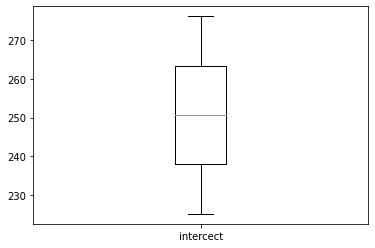

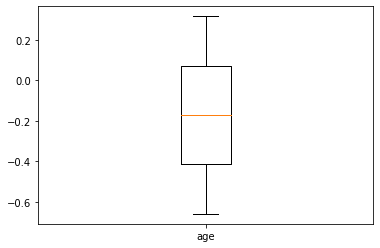

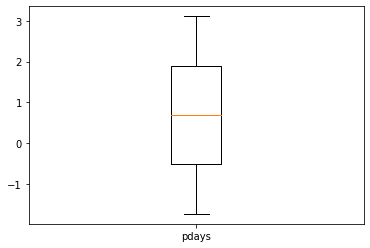

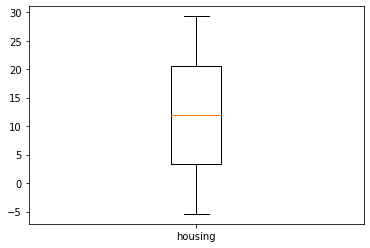

In [101]:
t = ["intercect"]
t.extend(x_arr)
#print(t)
for i,x in enumerate(quan2):
    plt.boxplot(x,labels= [t[i]])
    plt.show()

The CI are kinda big compared to the previous one. Also, they moved in place. in pdays we got something very weird when previously CI it wat (1,7) and now (-1,-3)